https://www.kaggle.com/code/yuliadewipuspitasari/rice-production-prediction-on-sumatera-island

https://www.kaggle.com/code/adhefirmansyah/explore-data

In [ ]:
#import library package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_validate
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer,mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_selection import RFE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/# MY JOBS/TensorLane - Big Data Solution Architect/3. driving measurable result/sumatran_plant.csv')

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Provinsi        224 non-null    object 
 1   Tahun           224 non-null    int64  
 2   Produksi        224 non-null    float64
 3   Luas Panen      224 non-null    float64
 4   Curah hujan     224 non-null    float64
 5   Kelembapan      224 non-null    float64
 6   Suhu rata-rata  224 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 12.4+ KB


In [ ]:
# check duplicates
df.duplicated().sum()

0

In [ ]:
# check missing value
df.isnull().sum()

,0
Provinsi,0
Tahun,0
Produksi,0
Luas Panen,0
Curah hujan,0
Kelembapan,0
Suhu rata-rata,0


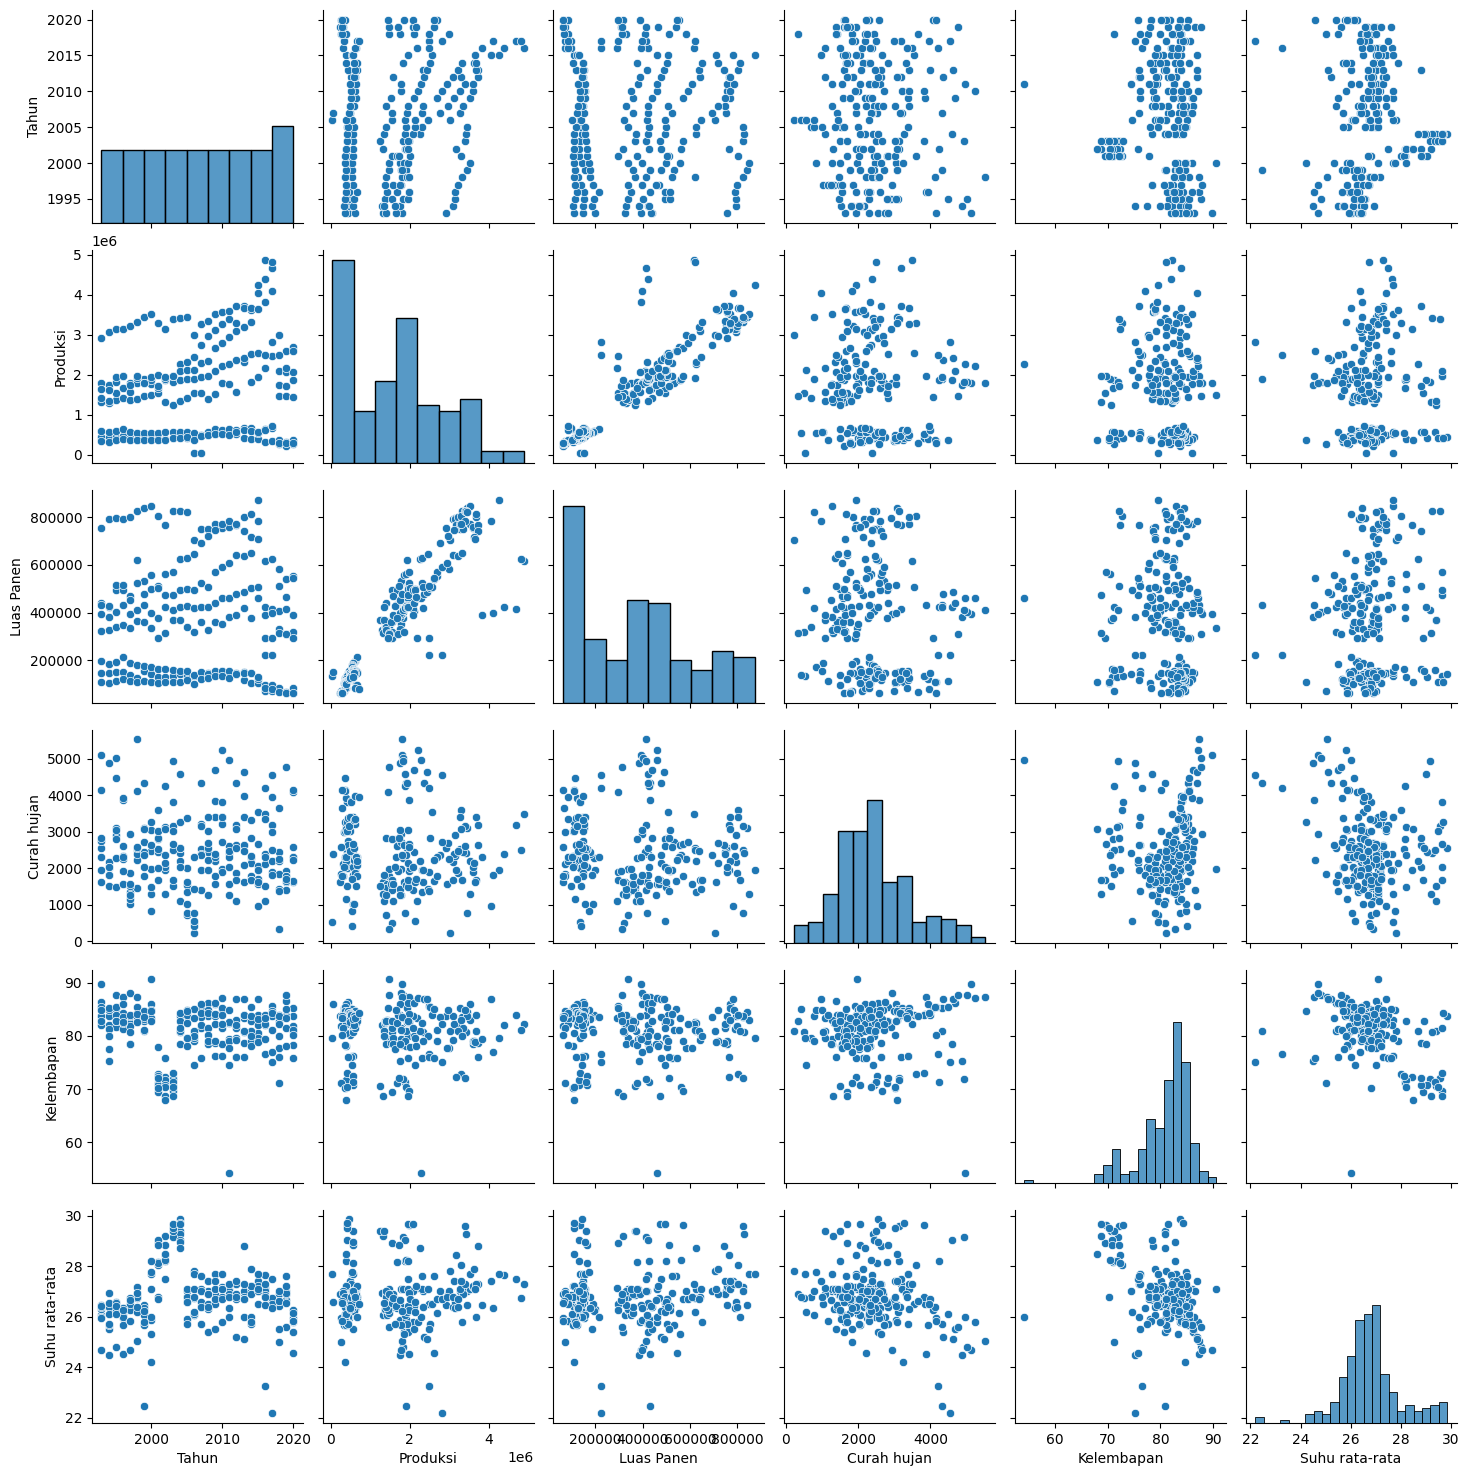

In [ ]:
sns.pairplot(data=df)

<Axes: xlabel='Luas Panen', ylabel='Produksi'>

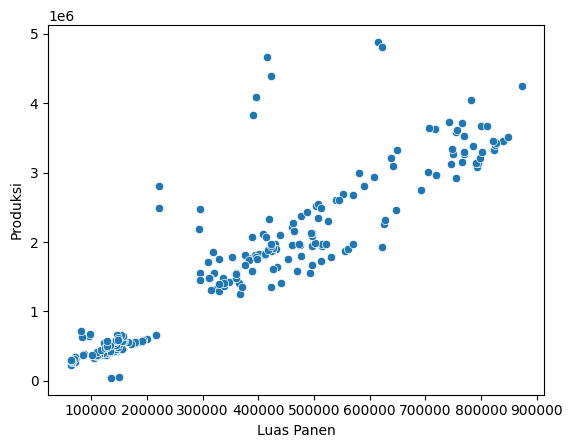

In [ ]:
sns.scatterplot(data=df, x="Luas Panen", y="Produksi")

In [ ]:
import pandas as pd
import plotly.graph_objects as go

aggregated_df = df.groupby('Tahun').sum().reset_index()

# Create a bar plot
fig = go.Figure(data=[go.Bar(
    x=aggregated_df['Tahun'].astype(str),
    y=aggregated_df['Produksi'],
    marker_color='skyblue'
)])

# Update layout to match Matplotlib's features
fig.update_layout(
    title='Total Production per Year',
    xaxis_title='Year',
    yaxis_title='Total Production',
    xaxis_tickangle=-45,  # Rotate x-axis labels if necessary
    yaxis=dict(gridcolor='lightgray', gridwidth=1, zeroline=False),
    margin=dict(l=50, r=50, t=50, b=100)  # Adjust layout to fit labels
)

# Show plot
fig.show()


In [ ]:
total_produksi_prov = df.groupby(['Provinsi'])['Produksi'].sum().sort_values(ascending = False).reset_index()

fig = px.bar(df, y=total_produksi_prov['Produksi'], x=total_produksi_prov['Provinsi'], text_auto='.2s',template='plotly_white',
             color = total_produksi_prov['Provinsi'])
fig.update_layout(title='Produksi Padi Berdasar Provinsi',
                   xaxis_title='Provinsi',
                   yaxis_title='Jumlah Produksi')
fig.show()

In [ ]:
timeline_prov = df.groupby(['Provinsi','Tahun'] )['Produksi'].sum().reset_index()

fig = px.line(x = timeline_prov['Tahun'], y = timeline_prov['Produksi'],color =timeline_prov['Provinsi'], template='plotly_white', markers=True)
fig.update_layout(title='Produksi Padi Dari Tahun ke Tahun Berdasarkan Provinsi',
                   xaxis_title='Tahun',
                   yaxis_title='Jumlah Produksi')
fig.show()

# DATA PREPROCESSING

## Dataset Split

In [ ]:
# Sort the dataframe by 'Tahun' in ascending order
df_sorted = df.sort_values(by='Tahun').reset_index(drop=True)

# Split the dataset
train = df_sorted.iloc[:212]      # First 212 rows for training
test = df_sorted.iloc[212:]    # Last 12 rows for testing

# Check the split
print(f"Train set:\n{train.shape[0]}\n")
print(f"Test set:\n{test.shape[0]}\n")

Train set:
212

Test set:
12



## Feature Engineering

<Axes: ylabel='Luas Panen'>

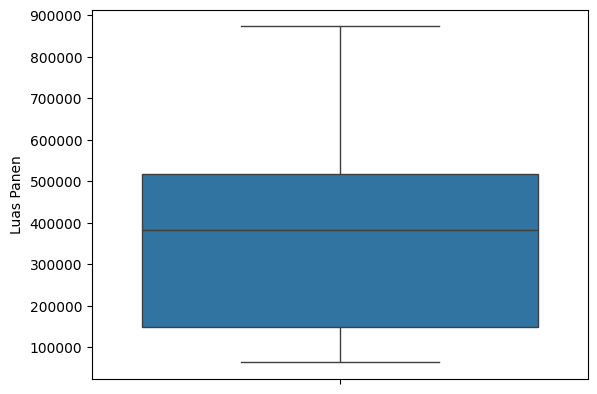

In [ ]:
sns.boxplot(data=train['Luas Panen'])

<Axes: >

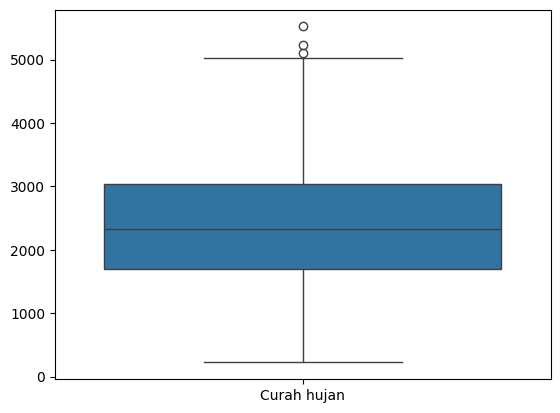

In [ ]:
sns.boxplot(data=train[['Curah hujan']])

<Axes: >

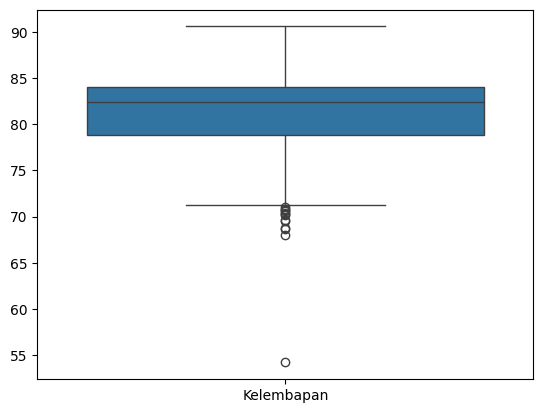

In [ ]:
sns.boxplot(data=train[['Kelembapan']])

<Axes: >

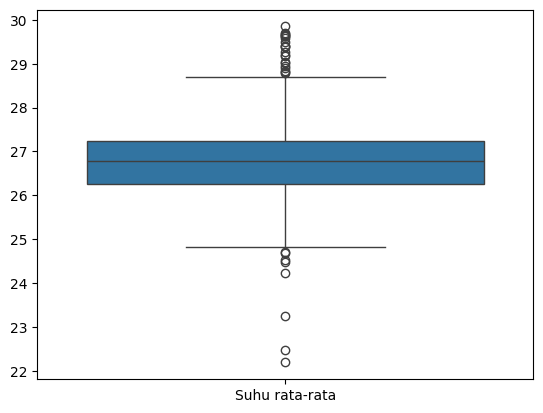

In [ ]:
sns.boxplot(data=train[['Suhu rata-rata']])

In [ ]:
# Calculate percentiles from the training set
q25_suhu = train['Suhu rata-rata'].quantile(0.25)
q75_suhu = train['Suhu rata-rata'].quantile(0.75)

q25_kelembapan = train['Kelembapan'].quantile(0.25)
q75_kelembapan = train['Kelembapan'].quantile(0.75)

def cap_column(df, column, q25, q75):
    df[column] = np.clip(df[column], q25, q75)

# Cap the columns in the training set
cap_column(train, 'Suhu rata-rata', q25_suhu, q75_suhu)
cap_column(train, 'Kelembapan', q25_kelembapan, q75_kelembapan)

<ipython-input-27-39728136f1af>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
x_train = train.drop(['Produksi'], axis = 1)
y_train = train['Produksi']

In [ ]:
# Define the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Provinsi'])
    ],
    remainder='passthrough'  # Keep the float column as it is
)

# Create a pipeline
pipeline = Pipeline(steps=[('transformer', column_transformer)])

In [ ]:
# Fit and transform the data
pipeline.fit(x_train)

transformed_data = pipeline.transform(x_train)

# The new columns generated by OneHotEncoder will have names such as 'object_column_A', 'object_column_B', etc.
x_train = pd.DataFrame(transformed_data, columns=pipeline.named_steps['transformer'].get_feature_names_out())

# MODEL DEFINITION

In [ ]:
# Initialize the XGBoost Regressor with default parameters
xgb_regressor = XGBRegressor()

# MODEL TRAINING

In [ ]:
# Fit the model
xgb_regressor.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# MODEL EVALUATION

Mean Absolute Error (MAE): Average absolute errors between predicted and true values.

Mean Squared Error (MSE): Average squared errors between predicted and true values.

Root Mean Squared Error (RMSE): Square root of the MSE, providing an error measure in the same units as the target.

R-squared (R²): Proportion of variance in the dependent variable that is predictable from the independent variables.

### train set evaluation

In [ ]:
scoring = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'rmse': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))),
    'r2': make_scorer(r2_score)
}

In [ ]:
cv_results = cross_validate(xgb_regressor, x_train, y_train, cv=10, scoring=scoring, return_train_score=False)

# Display results
print(f"Mean Absolute Error (MAE): {np.mean(cv_results['test_mae']):.4f}")
print(f"Mean Squared Error (MSE): {np.mean(cv_results['test_mse']):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.mean(cv_results['test_rmse']):.4f}")
print(f"R-squared (R2): {np.mean(cv_results['test_r2']):.4f}")

Mean Absolute Error (MAE): 205619.5258
Mean Squared Error (MSE): 186549365240.2204
Root Mean Squared Error (RMSE): 293606.5465
R-squared (R2): 0.8977


### test set evaluation

In [ ]:
cap_column(test, 'Suhu rata-rata', q25_suhu, q75_suhu)
cap_column(test, 'Kelembapan', q25_kelembapan, q75_kelembapan)

x_test = test.drop(['Produksi'], axis = 1)
y_test = test['Produksi']

# transform the data
transformed_data = pipeline.transform(x_test)

x_test = pd.DataFrame(transformed_data, columns=pipeline.named_steps['transformer'].get_feature_names_out())

<ipython-input-27-39728136f1af>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Make predictions
y_pred = xgb_regressor.predict(x_test)

# Calculate common metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Absolute Error (MAE): 133512.8454
Mean Squared Error (MSE): 30479694944.5096
Root Mean Squared Error (RMSE): 174584.3491
R-squared (R2): 0.9623


In [ ]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Create a scatter plot
fig = go.Figure()

# Scatter plot of actual vs predicted values
fig.add_trace(go.Scatter(
    x=results_df['Actual'],
    y=results_df['Predicted'],
    mode='markers',
    marker=dict(color='blue', size=8, opacity=0.6),
    name='Predicted vs Actual'
))

# Add a 45-degree line (identity line)
min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
fig.add_trace(go.Scatter(
    x=[min_val, max_val],
    y=[min_val, max_val],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Identity Line'
))

# Update layout
fig.update_layout(
    title='Actual vs Predicted Values',
    xaxis_title='Actual Values',
    yaxis_title='Predicted Values',
    xaxis=dict(showline=True, showgrid=True, zeroline=True),
    yaxis=dict(showline=True, showgrid=True, zeroline=True),
    margin=dict(l=50, r=50, t=50, b=50)
)

# Show plot
fig.show()

### Feature Importance

In [ ]:
importance = xgb_regressor.get_booster().get_score(importance_type='weight')

In [ ]:
# Convert feature importances to a DataFrame for easier plotting
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot using Plotly
fig = go.Figure(data=[go.Bar(
    x=importance_df['Feature'],
    y=importance_df['Importance'],
    marker_color='skyblue'
)])

# Update layout
fig.update_layout(
    title='Feature Importance from XGBRegressor',
    xaxis_title='Feature',
    yaxis_title='Importance',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    yaxis=dict(gridcolor='lightgray', gridwidth=1, zeroline=False),
    margin=dict(l=50, r=50, t=50, b=150)  # Adjust layout to fit labels
)

# Show plot
fig.show()

# PROJECT SUMMARY

prompt :

1. its about developing a ml model to predict harvest yield of different province in sumatera on certain year.
2. the dataset is around 224 sample with feature such as the province, year, land area, humidity, rainfall rate, and average temperature.
3. i am using xgb regressor for the model with capping as feature engineering for numerical feature
4. the evaluation metric for train set :
Mean Absolute Error (MAE): 205619.5258
Mean Squared Error (MSE): 186549365240.2204
Root Mean Squared Error (RMSE): 293606.5465
R-squared (R2): 0.8977

the evaluation metric for test set :
Mean Absolute Error (MAE): 133512.8454
Mean Squared Error (MSE): 30479694944.5096
Root Mean Squared Error (RMSE): 174584.3491
R-squared (R2): 0.9623
5. next i used shap for feature importance and the significantly important feature are the year, the rainfall rate, and harvest area, reasonable based on eda performed

### 1. Project Overview

**Objective:**  
The primary goal of this project was to develop a machine learning model to predict the harvest yield for various provinces in Sumatra for a specific year. This involved creating a predictive model to assist in agricultural planning and resource allocation.

**Dataset:**  
The dataset consists of approximately 224 samples, encompassing features such as the province, year, land area, humidity, rainfall rate, and average temperature. This dataset is designed to capture the key variables influencing harvest yield across different regions and times.

**Methodology:**  
The XGBoost regressor was employed as the primary model for predicting harvest yields. Feature engineering techniques included capping for numerical features to improve model performance and stability. SHAP (SHapley Additive exPlanations) was used to analyze feature importance and understand the contribution of each feature to the model’s predictions.

### 2. Key Findings

**Model Performance:**  
- **Train Set:**
  - Mean Absolute Error (MAE): 205,619.53
  - Mean Squared Error (MSE): 186,549,365,240.22
  - Root Mean Squared Error (RMSE): 293,606.55
  - R-squared (R²): 0.8977

- **Test Set:**
  - Mean Absolute Error (MAE): 133,512.85
  - Mean Squared Error (MSE): 30,479,694,944.51
  - Root Mean Squared Error (RMSE): 174,584.35
  - R-squared (R²): 0.9623

The model demonstrated strong performance on both the training and test sets, with notably better metrics on the test set, indicating good generalization capabilities.

**Feature Importance:**  
Feature importance analysis via SHAP revealed that the most influential features were the year, rainfall rate, and harvest area. These features were critical in predicting harvest yield, aligning with expectations from exploratory data analysis (EDA).

**Challenges:**  
Key challenges included handling data imbalance and ensuring that the model did not overfit to the training data. These were mitigated through careful feature engineering and the use of robust cross-validation techniques.

### 3. Conclusion

**Insights:**  
The model provides valuable insights into the factors affecting harvest yield, particularly highlighting the importance of year, rainfall, and land area. These insights can guide future agricultural planning and policy-making in Sumatra.

**Model Interpretability:**  
The XGBoost model, while accurate, is more complex and less interpretable compared to simpler models. However, SHAP analysis helped in understanding the model’s decisions and the relative importance of different features, balancing the trade-off between accuracy and interpretability.

**Limitations:**  
The study’s limitations include the relatively small size of the dataset, which may affect the robustness of the model. Additionally, assumptions made during feature engineering and model training might not account for all real-world variables.

**Recommendations:**  
Future work should involve expanding the dataset to include more samples and potentially additional features, such as soil quality or crop variety. Testing other models and techniques could also be beneficial. Applying the model in real-world scenarios and incorporating feedback would help in refining its accuracy and applicability.

### 4. Final Thoughts

**Impact:**  
The findings from this project have the potential to significantly impact agricultural practices in Sumatra by providing a data-driven approach to predict harvest yields. This can lead to more efficient resource management and better planning.

**Next Steps:**  
The next steps include deploying the model in a real-world setting, engaging with stakeholders to validate and use the model's predictions, and exploring further research to enhance the model’s accuracy and applicability in different contexts or regions.